# Import des outils / jeu de données

In [1]:
from src.utils import init_notebook
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
init_notebook()

In [3]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)
event_times = df["day_succ"]
event_observed = df["Status"]

event_times_no_censoring = df["day_succ"][df["Status"] == 1]
event_observed_no_censoring = df["Status"][df["Status"] == 1]

On ne s'intéresse qu'aux variables suivantes

In [4]:
df = df[
    [
        "day_succ",
        "Status",
        "has_video",
        "facebook_connected",
        "goal",
        "facebook_friends",
    ]
]

# Régression linéaire

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [6]:
X = df.drop(['day_succ', 'Status'], axis=1)
y = event_times

## Modèle explicatif

In [7]:
# Add constant
X = sm.add_constant(X)

# Define and fit model
linear_explic = sm.OLS(y, X).fit()

# Predict
y_pred_explic = linear_explic.predict(X)

# Calculate residuals
residuals_explic = y_pred_explic - y

### Diagnostic

In [8]:
linear_explic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               day_succ   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     12.36
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           5.40e-10
Time:                        18:32:51   Log-Likelihood:                -16973.
No. Observations:                4175   AIC:                         3.396e+04
Df Residuals:                    4170   BIC:                         3.399e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 28.8337      0.583     49.488      0.000      27.691      29.976
has_video             -1.8480      0.557     -3.317      0.001      -2.940      -0.756
facebook_connected     0.4810      0.473      1.016      0.310      -0.447       1.409
goal                   5.0693      0.877      5.777      0.000       3.349       6.790
facebook_friends      -0.5737      0.245     -2.338      0.019      -1.055      -0.093
==============================================================================
Omnibus:                       17.062   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.339
Skew:                           0.142   Prob(JB):                     0.000172
Kurtosis:                       3.137   Cond. No.                         6.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Un objectif financier (`goal`) ambitieux signifie plus de temps avant d'atteindre le financement. C'est la variable la plus influente.
* Avoir une vidéo pour promouvoir le projet est très favorable.
* Plus le compte facebook du projet a d'abonnés, plus la durée de financement est courte. 
* `facebook_connected` engendre un problème de multicolinéarité avec `facebook_friends` et n'est donc pas significative. On la retire de l'analyse.

In [17]:
# Drop variable
X = X.drop("facebook_connected", axis=1)

Text(0.5, 1.0, 'Distribution des résidus')

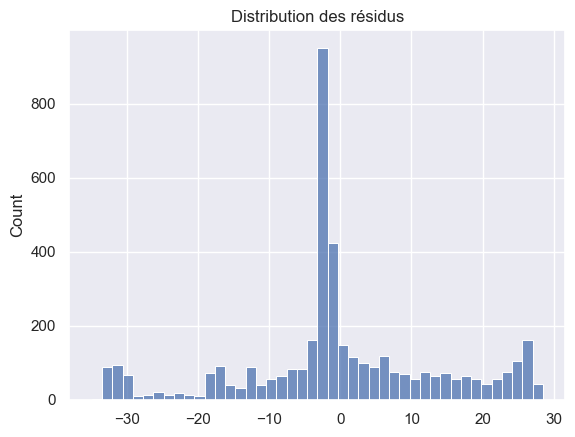

In [9]:
sns.histplot(residuals_explic)
plt.title("Distribution des résidus")

## Modèle prédictif

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
linear = LinearRegression(fit_intercept=False)
linear.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [25]:
# Get coefficients
coefficients_df = pd.DataFrame({
    'Variable': [col for col in X.columns],
    'Coefficient': linear.coef_.tolist()
})
coefficients_df

,Variable,Coefficient
0,const,29.404773
1,has_video,-2.011150
2,goal,4.850214
3,facebook_friends,-0.388278


In [26]:
# Evaluate model prediction capacity
y_pred = linear.predict(X_test)

linear_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
linear_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

print(f"Mean squared error = {round(linear_mse)}")
print(f"Mean absolute error = {round(linear_mae)}")

Mean squared error = 198
Mean absolute error = 10


En moyenne, le modèle de régression linéaire parvient à prévoir la durée nécessaire au financement à 10 jours près. 

# Forêt aléatoire

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

In [30]:
# Create and train a Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
# Get feature importances
feature_importances = random_forest.feature_importances_

# Display feature importances
importances_df = pd.DataFrame({
    'Variable': [col for col in X.columns],
    'Importance': feature_importances.tolist()
})
importances_df

,Variable,Importance
0,const,0.00000
1,has_video,0.03096
2,goal,0.41027
3,facebook_friends,0.55877


In [34]:
# Evaluate model prediction capacity
y_pred_rf = random_forest.predict(X_test)

# Calculate Mean Squared Error and Mean Absolute Error
rf_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
rf_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)

print(f"Random Forest Mean Squared Error = {round(rf_mse, 2)}")
print(f"Random Forest Mean Absolute Error = {round(rf_mae, 2)}")


Random Forest Mean Squared Error = 229.26
Random Forest Mean Absolute Error = 11.66


En moyenne, le modèle de forêt aléatoire parvient à prévoir la durée nécessaire au financement à 12 jours près.  

**On conservera donc le modèle de régression linéaire pour la prédiction.**